In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from time import time
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

#link of the data : https://www.kaggle.com/datasets/prasoonkottarathil/btcinusd?select=BTC-2021min.csv
df = pd.read_csv("./Desktop/borsabut/BTC-2021min.csv")

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df_hourly = df.resample('1H').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})

df

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2022-03-01 03:43:00,1646106180,BTC/USD,43046.58,43046.58,43046.58,43046.58,0.000000,0.000000
2022-03-01 03:42:00,1646106120,BTC/USD,43046.58,43046.58,43046.58,43046.58,0.000000,0.000000
2022-03-01 03:41:00,1646106060,BTC/USD,43018.23,43046.59,43018.23,43046.58,0.142977,6154.673021
2022-03-01 03:40:00,1646106000,BTC/USD,43022.24,43022.24,43016.03,43016.03,0.009230,397.037957
2022-03-01 03:39:00,1646105940,BTC/USD,43035.16,43035.16,42999.44,42999.44,0.820950,35300.390268
...,...,...,...,...,...,...,...,...
2021-01-01 00:05:00,1609459500,BTC/USD,29021.86,29023.38,28982.33,28999.50,1.062360,30807.899250
2021-01-01 00:04:00,1609459440,BTC/USD,29048.13,29057.73,29035.61,29045.19,1.446538,42014.959434
2021-01-01 00:03:00,1609459380,BTC/USD,29037.68,29069.39,29019.00,29048.13,2.189621,63604.382387


**While one minute data is much more stochastic, we are going to turn it higher time frames.**

In [2]:
df_hourly

,open,high,low,close
date,,,,
2021-01-01 00:00:00,29007.31,29099.00,28774.64,29056.94
2021-01-01 01:00:00,29070.66,29543.93,29010.36,29479.12
2021-01-01 02:00:00,29484.39,29535.95,29189.34,29249.33
2021-01-01 03:00:00,29249.33,29414.48,29216.61,29345.63
2021-01-01 04:00:00,29351.85,29458.27,29121.80,29290.38
...,...,...,...,...
2022-02-28 23:00:00,43085.30,43364.81,42892.37,43178.98
2022-03-01 00:00:00,43221.71,43750.00,43185.48,43589.44
2022-03-01 01:00:00,43594.14,43667.86,43235.45,43296.36


In [3]:
df_hourly_filtered = df_hourly.drop(df_hourly.index[(df_hourly.index.hour >= 0) & (df_hourly.index.hour < 3)])

# Group the data by four-hour intervals starting at 3:00 AM
df_4hourly = df_hourly_filtered.resample('4H').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})
df_4hourly.index += timedelta(hours=3)

print(df_4hourly)


                         open      high       low     close
date                                                       
2021-01-01 03:00:00  29249.33  29414.48  29216.61  29345.63
2021-01-01 07:00:00  29351.85  29458.27  28896.66  29173.17
2021-01-01 11:00:00  29179.01  29490.00  28947.70  29390.34
2021-01-01 15:00:00  29390.34  29700.00  29100.00  29261.96
2021-01-01 19:00:00  29261.96  29436.33  28720.00  29131.54
...                       ...       ...       ...       ...
2022-02-28 11:00:00  38375.17  38688.88  38104.13  38367.53
2022-02-28 15:00:00  38365.56  40912.56  37914.32  40846.38
2022-02-28 19:00:00  40860.33  41476.20  40524.73  41362.52
2022-02-28 23:00:00  41361.99  44256.08  41284.11  43178.98
2022-03-01 03:00:00  43160.97  43161.72  42870.04  43046.58

[2545 rows x 4 columns]


In [4]:
df_hourly_filtered

,open,high,low,close
date,,,,
2021-01-01 03:00:00,29249.33,29414.48,29216.61,29345.63
2021-01-01 04:00:00,29351.85,29458.27,29121.80,29290.38
2021-01-01 05:00:00,29294.58,29300.15,29158.86,29242.10
2021-01-01 06:00:00,29242.10,29317.56,29156.48,29245.54
2021-01-01 07:00:00,29245.54,29253.61,28896.66,29173.17
...,...,...,...,...
2022-02-28 20:00:00,41361.99,41971.00,41284.11,41914.97
2022-02-28 21:00:00,41917.09,41917.09,41542.60,41659.53
2022-02-28 22:00:00,41657.23,44256.08,41650.29,42907.32


In [5]:
df_daily = df.resample('1D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})
df_daily

,open,high,low,close
date,,,,
2021-01-01,29007.31,29700.00,28720.00,29402.64
2021-01-02,29410.77,33333.00,29050.00,32216.53
2021-01-03,32216.51,34800.00,31977.45,33097.83
2021-01-04,33068.83,33669.76,27734.00,32005.88
2021-01-05,32054.23,34500.00,29936.26,34039.05
...,...,...,...,...
2022-02-25,38360.93,39727.97,38027.61,39231.64
2022-02-26,39242.64,40330.99,38600.00,39146.66
2022-02-27,39146.66,39886.92,37015.74,37712.68


In [6]:
df_weekly = df.resample('1W').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})
df_weekly

,open,high,low,close
date,,,,
2021-01-03,29007.31,34800.00,28720.00,33097.83
2021-01-10,33068.83,42000.00,27734.00,38173.73
2021-01-17,38164.88,40112.78,30261.13,35819.25
2021-01-24,35826.36,37874.71,28800.00,32288.83
2021-01-31,32289.06,38620.00,29150.49,33141.38
...,...,...,...,...
2022-02-06,37914.10,42701.86,36264.55,42420.24
2022-02-13,42420.24,45850.00,41682.11,42077.74
2022-02-20,42078.53,44785.66,37974.18,38373.90


Text(0, 0.5, 'Price')

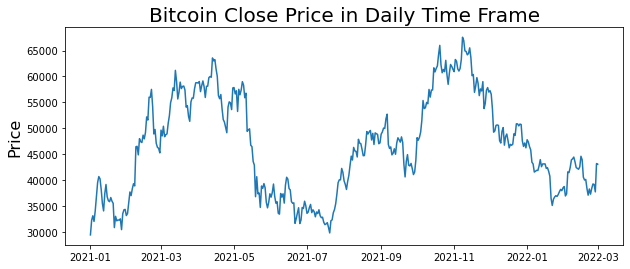

In [7]:
plt.figure(figsize=(10,4))
plt.plot(df_daily["close"])
plt.title('Bitcoin Close Price in Daily Time Frame', fontsize=20)
plt.ylabel('Price', fontsize=16)

<BarContainer object of 26 artists>

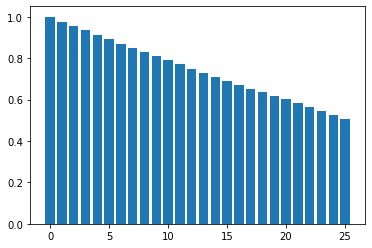

In [8]:
acf_vals = acf(df_daily["close"])
num_lags = 26
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 26 artists>

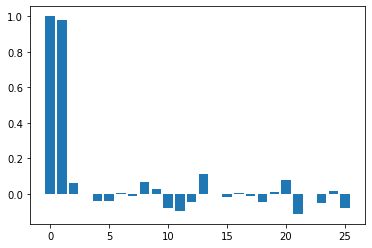

In [9]:
pacf_vals = pacf(df_daily["close"])
num_lags = 26
plt.bar(range(num_lags), pacf_vals[:num_lags])

**To getting better results for acf and pacf we are going to delete trend from data with taking difference in data.**

In [10]:
# deleting trend 
dclose_diff = df_daily["close"].diff()[1:]
dopen_diff = df_daily["open"].diff()[1:]
dhigh_diff = df_daily["high"].diff()[1:]
dlow_diff = df_daily["low"].diff()[1:]
len(dclose_diff)

424

Text(0, 0.5, 'difference')

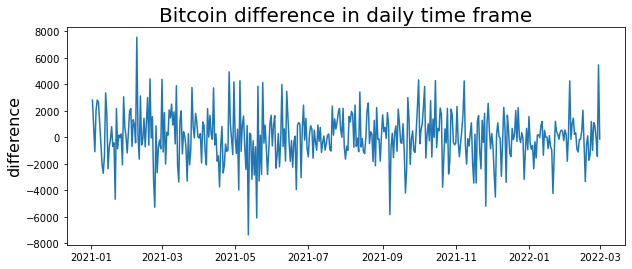

In [11]:
plt.figure(figsize=(10,4))
plt.plot(dclose_diff)
plt.title('Bitcoin difference in daily time frame', fontsize=20)
plt.ylabel('difference', fontsize=16)


In [12]:
dclose_diff

date
2021-01-02    2813.89
2021-01-03     881.30
2021-01-04   -1091.95
2021-01-05    2033.17
2021-01-06    2810.89
               ...   
2022-02-25     854.76
2022-02-26     -84.98
2022-02-27   -1433.98
2022-02-28    5466.30
2022-03-01    -132.40
Freq: D, Name: close, Length: 424, dtype: float64

<BarContainer object of 26 artists>

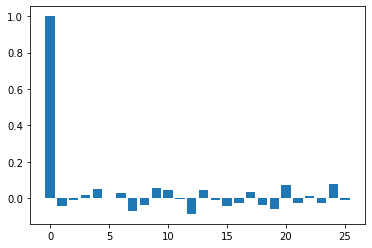

In [13]:
acf_vals = acf(dclose_diff)
num_lags = 26
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 25 artists>

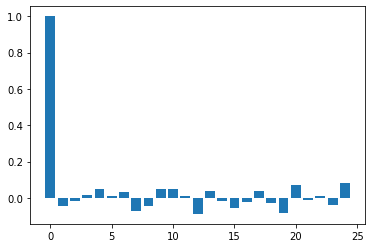

In [14]:
pacf_vals = pacf(dclose_diff)
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])

**While acf and pacf are not statistically significant in daily time frame we have to work with higher time frames.**

In [15]:
wclose_diff = df_weekly["close"].diff()[1:]
wopen_diff = df_weekly["open"].diff()[1:]
whigh_diff = df_weekly["high"].diff()[1:]
wlow_diff = df_weekly["low"].diff()[1:]
len(wclose_diff)

61

Text(0, 0.5, 'Difference')

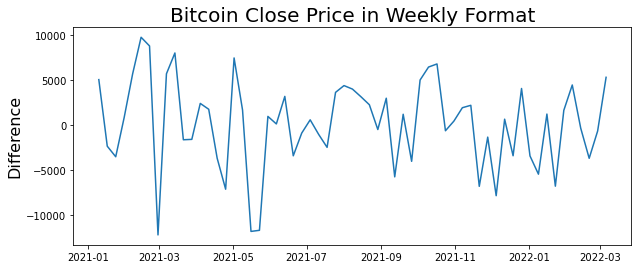

In [16]:
plt.figure(figsize=(10,4))
plt.plot(wclose_diff)
plt.title('Bitcoin Close Price in Weekly Format', fontsize=20)
plt.ylabel('Difference', fontsize=16)

<BarContainer object of 18 artists>

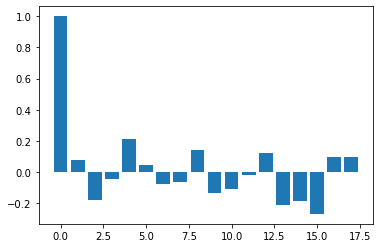

In [17]:
acf_vals = acf(wclose_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 18 artists>

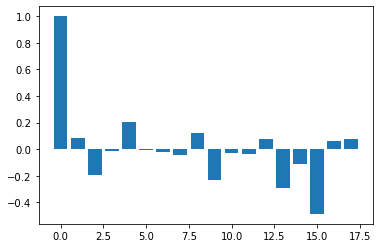

In [18]:
pacf_vals = pacf(wclose_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

**15th lag is significant enough to get better estimate in both acf and pacf.**
**Also data has a seasonal attribute with to highs, we are going two use Seasonal ARIMA model.**

In [19]:
train_data = df_weekly["close"][:59]
test_data = df_weekly["close"][59:]

**While we take difference from non-seasonal data, our non-seasonal order's Integrated part is equal to 1.**

**AR and MA part will be evaluated in seasonal order. So they are equal to 1 in seasonal order. The frequency of the data is 15 from acf and pacf. So frequency order is equal to 15.**

In [20]:
order = (0, 1, 0)
seasonal_order = (1, 0, 1, 15)
model = SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 0, 1, 15))


In [21]:
#fitting model
model_fit = model.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [22]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

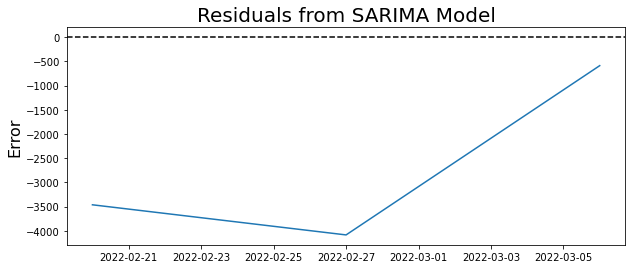

In [23]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Price')

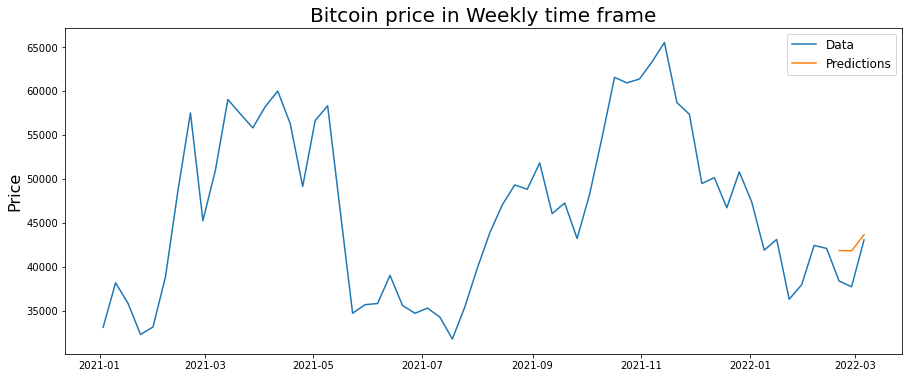

In [24]:
plt.figure(figsize=(15,6))

plt.plot(df_weekly["close"])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Bitcoin price in Weekly time frame', fontsize=20)
plt.ylabel('Price', fontsize=16)


In [25]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0708


**We are getting error above %5. So in order to reduce error, we should go with rolling forecast. The job of the rolling forecast is that after making the forecast for the next step, when the data for the next step appears, it adds this data to the train data and makes a more accurate prediction of the next step.**

**For example we have 1 to k train data and we are predicting (k+1)th data. When we learn the value of (k+1), our train data changes from 1 to k+1 to estimate (k+2).**

In [26]:
train_data = df_weekly["close"][:59]
test_data = df_weekly["close"][59:]

In [27]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = df_weekly["close"][:train_end-timedelta(weeks=1)]
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [28]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

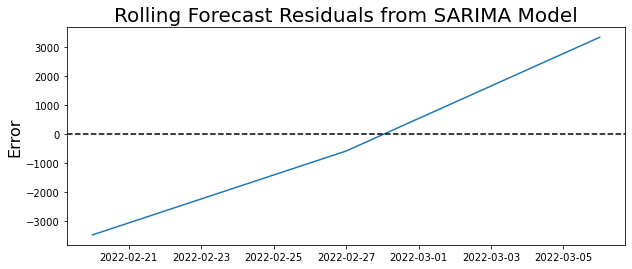

In [29]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Price')

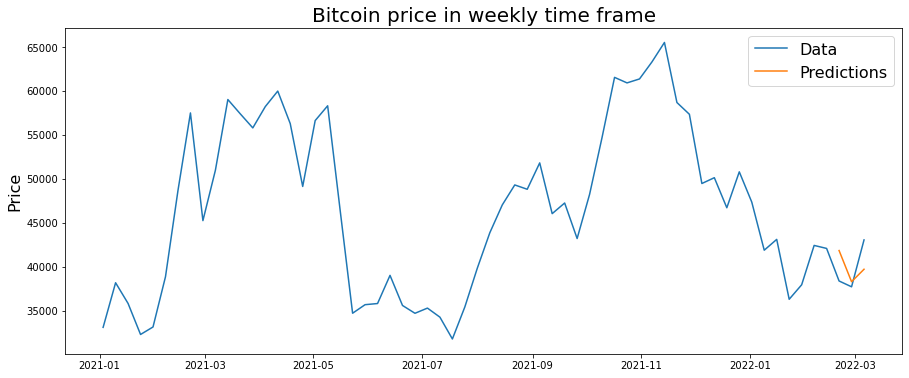

In [30]:
plt.figure(figsize=(15,6))

plt.plot(df_weekly["close"])
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bitcoin price in weekly time frame', fontsize=20)
plt.ylabel('Price', fontsize=16)


In [31]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0611


**We were able to lower our error but it's still above 5%. I think because my observations are really low, I couldn't forecast correctly. I am going to add more data.**

In [32]:
df_expand = pd.DataFrame(df_weekly["close"])

df_expand

,close
date,
2021-01-03,33097.83
2021-01-10,38173.73
2021-01-17,35819.25
2021-01-24,32288.83
2021-01-31,33141.38
...,...
2022-02-06,42420.24
2022-02-13,42077.74
2022-02-20,38373.90


In [33]:
df_oldval = pd.DataFrame({"date":["2020-1-5","2020-1-12","2020-1-19","2020-1-26","2020-2-2","2020-2-9","2020-2-16","2020-2-23","2020-3-1",
                                 "2020-3-8","2020-3-15","2020-3-22","2020-3-29","2020-4-5","2020-4-12","2020-4-19","2020-4-26","2020-5-3",
                                  "2020-5-10","2020-5-17","2020-5-24","2020-5-31","2020-6-7","2020-6-14","2020-6-21","2020-6-28","2020-7-5",
                                  "2020-7-12","2020-7-19","2020-7-26","2020-8-2","2020-8-9","2020-8-16","2020-8-23","2020-8-30","2020-9-6",
                                  "2020-9-13","2020-9-20","2020-9-27","2020-10-4","2020-10-11","2020-10-18","2020-10-25",
                                  "2020-11-1","2020-11-8","2020-11-15","2020-11-22","2020-11-29","2020-12-6","2020-12-13", 
                                  "2020-12-20", "2020-12-27"],
                    "close":[7358,8185,8701,8615,9331,10151,9917,9936,8531,8033,5361,5816,5881,6772,6903,7120,7693,8894,8722,9681,8718,9448,9747,
                        9350,9294,9116,9069,9303,9209,9931,11071,11681,11910,11648,11711,10256,10333,10920,
                        10774,10666,11369,11503, 13029, 13761, 15475, 15957, 18413, 18185, 19358, 19175, 23455, 26281]})
df_oldval['date'] = pd.to_datetime(df_oldval['date'])

# Set the date column as the index
df_oldval.set_index('date', inplace=True)
new_close = pd.concat([df_oldval,df_expand])
new_close

,close
date,
2020-01-05,7358.00
2020-01-12,8185.00
2020-01-19,8701.00
2020-01-26,8615.00
2020-02-02,9331.00
...,...
2022-02-06,42420.24
2022-02-13,42077.74
2022-02-20,38373.90


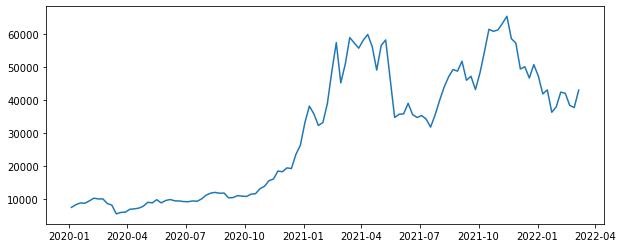

In [34]:
plt.figure(figsize=(10,4))
plt.plot(new_close["close"])
new_close = new_close.asfreq(pd.infer_freq(new_close.index))

In [35]:
new_diff = new_close.diff()[1:]

Text(0, 0.5, 'Difference')

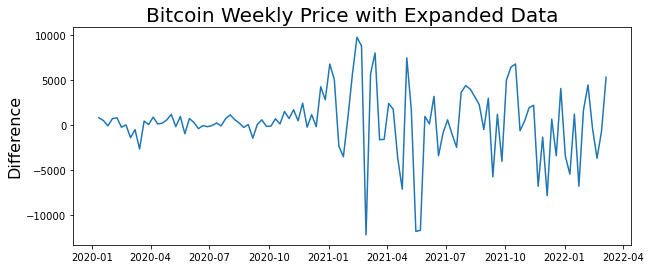

In [36]:
plt.figure(figsize=(10,4))
plt.plot(new_diff)
plt.title('Bitcoin Weekly Price with Expanded Data', fontsize=20)
plt.ylabel('Difference', fontsize=16)

<BarContainer object of 20 artists>

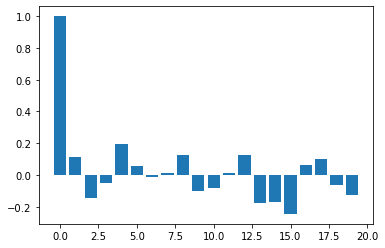

In [37]:
acf_vals = acf(new_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 20 artists>

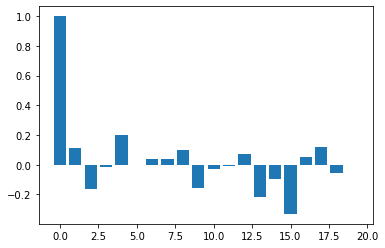

In [38]:
pacf_vals = pacf(new_diff)
num_lags = 20
plt.bar(range(num_lags), pacf_vals[:num_lags])

**Choosing 15 lags is the best option for both acf and pacf. Now our data is better in terms of statistical significance.**

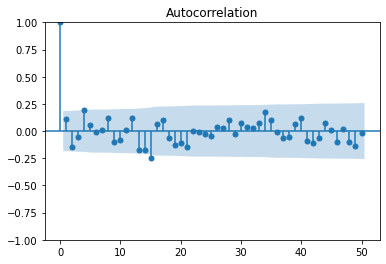

In [39]:
#
import statsmodels.api as sm

# Load the time series data
sm.graphics.tsa.plot_acf(new_diff, lags=50, alpha=0.05)

# Show the plot
plt.show()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


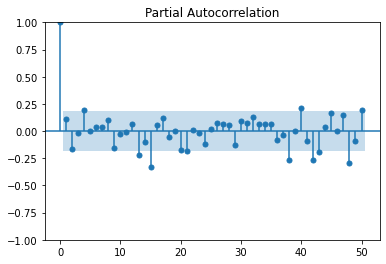

In [40]:
sm.graphics.tsa.plot_pacf(new_diff, lags=50, alpha=0.05)

plt.show()

**As we can see, increasing the number of lags in pacf does not help much, but gives negative results for acf. So 15 lags are enough for us.**

In [41]:
train_data = new_close["close"][25:110]
test_data = new_close["close"][110:]


In [42]:
train_data

date
2020-06-28     9116.00
2020-07-05     9069.00
2020-07-12     9303.00
2020-07-19     9209.00
2020-07-26     9931.00
                ...   
2022-01-09    41875.81
2022-01-16    43107.70
2022-01-23    36293.62
2022-01-30    37941.82
2022-02-06    42420.24
Freq: W-SUN, Name: close, Length: 85, dtype: float64

**Avoiding first 25 values give lower mean absolute error. I noticed when trying manually. The behavior of the price may have changed since then.**

In [43]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 15)

model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order, freq = "W")

In [44]:

model_fit = model.fit()


In [45]:
model_fit = model.fit()
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

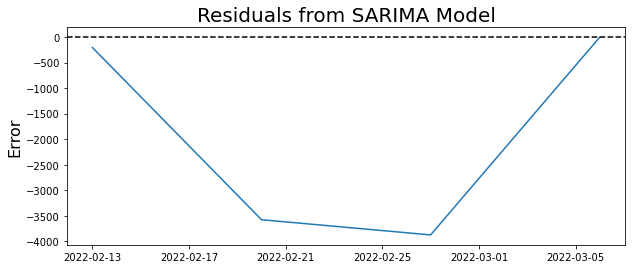

In [46]:

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Price')

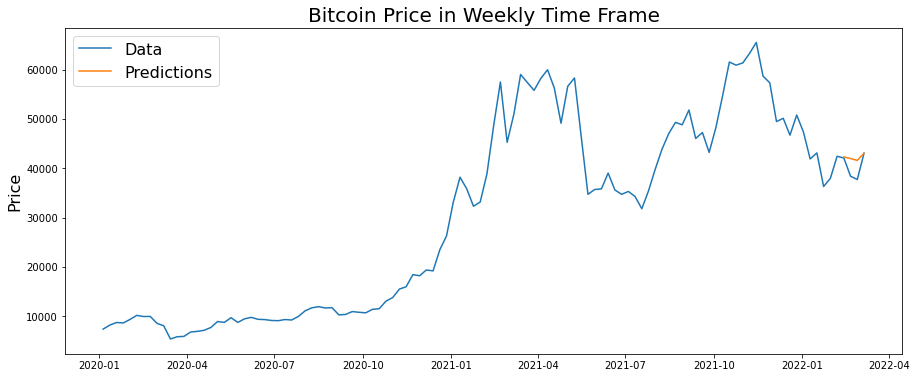

In [47]:
plt.figure(figsize=(15,6))

plt.plot(new_close)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bitcoin Price in Weekly Time Frame', fontsize=20)
plt.ylabel('Price', fontsize=16)


In [48]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0503


**We got an almost good result. We can make it better with rolling forecast.**

In [49]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = new_close[:train_end-timedelta(weeks=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [50]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

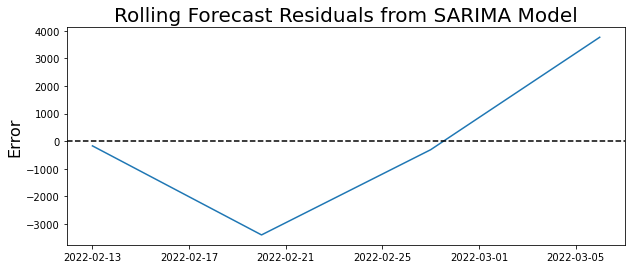

In [51]:
rolling_residuals = test_data - rolling_predictions
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Price')

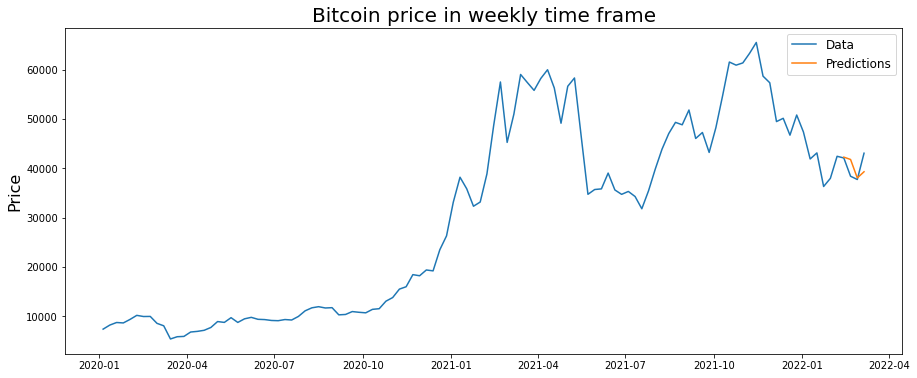

In [52]:
plt.figure(figsize=(15,6))

plt.plot(new_close)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Bitcoin price in weekly time frame', fontsize=20)
plt.ylabel('Price', fontsize=16)

In [53]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0471


**We were able to get a result below 5%. The similarity of our estimation with the true value also shows us that we got a good result.**

**Our model chooses bias correctly. Also gives opportunity to trade bitcoin.**

In [54]:
pip install requests pandas


Note: you may need to restart the kernel to use updated packages.


In [55]:
import requests
import time
import pandas as pd
from datetime import datetime, timedelta

# Binance API endpoint
url = "https://api.binance.com/api/v3/klines"

# 5 years ago from now
five_years_ago = datetime.now() - timedelta(days=5*365)
# Convert to milliseconds
startTime = int(time.mktime(five_years_ago.timetuple()) * 1000)

# Parameters
params = {
    'symbol': 'BTCUSDT',
    'interval': '1w',
    'startTime': startTime,
    'limit': 1000
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()

    df = pd.DataFrame(data, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
    df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')

    # Keep only 'Close time' and 'Close' columns
    df = df[['Close time', 'Close']]

    print(df)
else:
    print(f"Error: {response.status_code}")


                 Close time           Close
0   2018-07-08 23:59:59.999   6712.10000000
1   2018-07-15 23:59:59.999   6353.01000000
2   2018-07-22 23:59:59.999   7394.79000000
3   2018-07-29 23:59:59.999   8211.00000000
4   2018-08-05 23:59:59.999   7024.19000000
..                      ...             ...
256 2023-06-04 23:59:59.999  27115.21000000
257 2023-06-11 23:59:59.999  25925.55000000
258 2023-06-18 23:59:59.999  26339.97000000
259 2023-06-25 23:59:59.999  30462.66000000
260 2023-07-02 23:59:59.999  30840.42000000

[261 rows x 2 columns]


In [56]:
# Convert 'Close time' to 'YYYY-MM-DD HH:MM' format
df['Close time'] = df['Close time'].dt.strftime('%Y-%m-%d %H:%M')

# Convert 'Close' to float and round to 2 decimal places
df['Close'] = df['Close'].astype(float).round(2)
df = df.drop(df.index[-1])
print(df)


           Close time     Close
0    2018-07-08 23:59   6712.10
1    2018-07-15 23:59   6353.01
2    2018-07-22 23:59   7394.79
3    2018-07-29 23:59   8211.00
4    2018-08-05 23:59   7024.19
..                ...       ...
255  2023-05-28 23:59  28065.00
256  2023-06-04 23:59  27115.21
257  2023-06-11 23:59  25925.55
258  2023-06-18 23:59  26339.97
259  2023-06-25 23:59  30462.66

[260 rows x 2 columns]


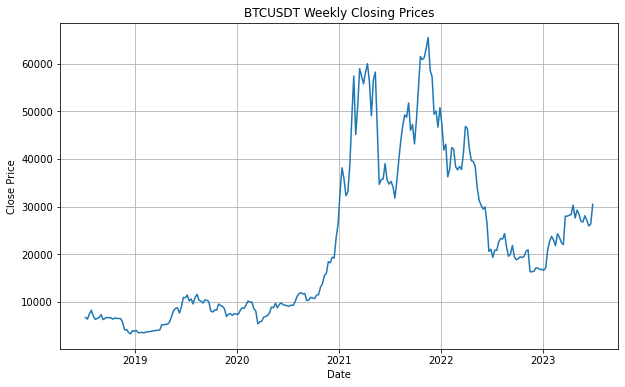

In [57]:
import matplotlib.pyplot as plt

# Convert 'Close time' back to datetime for plotting
df['Close time'] = pd.to_datetime(df['Close time'])

# Convert 'Close' to float for plotting
df['Close'] = df['Close'].astype(float)

# Create plot
plt.figure(figsize=(10,6))
plt.plot(df['Close time'], df['Close'])
plt.title('BTCUSDT Weekly Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


In [58]:
dclose_diff = df["Close"].diff()[1:]
len(dclose_diff)

259

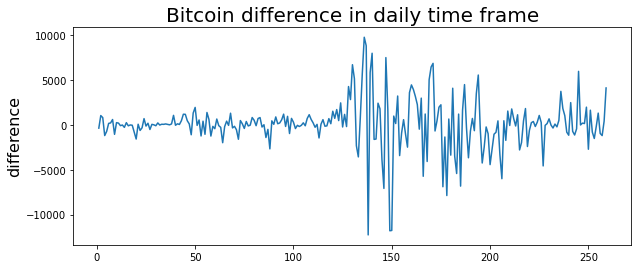

In [59]:
plt.figure(figsize=(10,4))
plt.plot(dclose_diff)
plt.title('Bitcoin difference in daily time frame', fontsize=20)
plt.ylabel('difference', fontsize=16)
plt.show()

In [60]:
df['Close diff'] = df['Close'].diff()
df = df.dropna()  # drop the first row which is NaN


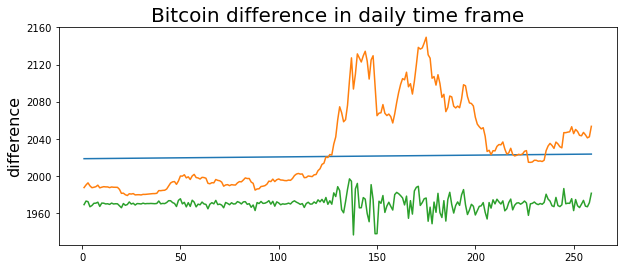

In [61]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('Bitcoin difference in daily time frame', fontsize=20)
plt.ylabel('difference', fontsize=16)
plt.show()

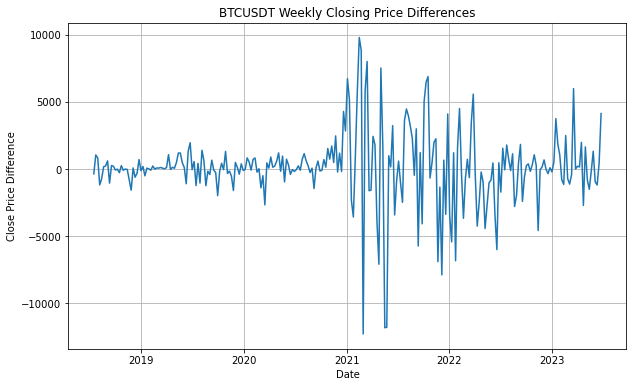

In [62]:
import matplotlib.pyplot as plt

# Create plot
plt.figure(figsize=(10,6))
plt.plot(df['Close time'], df['Close diff'])
plt.title('BTCUSDT Weekly Closing Price Differences')
plt.xlabel('Date')
plt.ylabel('Close Price Difference')
plt.grid(True)
plt.show()


<BarContainer object of 25 artists>

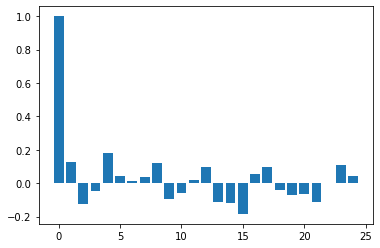

In [63]:
acf_vals = acf(df['Close diff'])
num_lags = 25
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 25 artists>

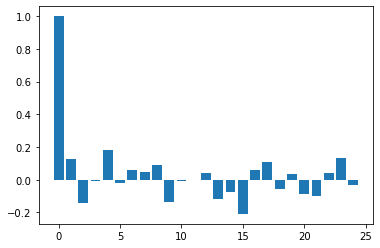

In [64]:
pacf_vals = pacf(df['Close diff'])
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])

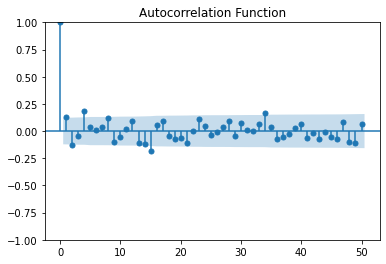

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


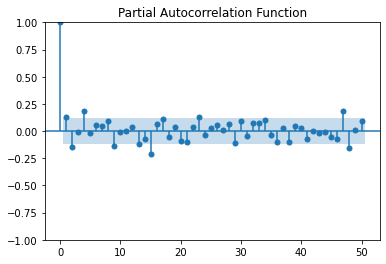

In [65]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(df['Close diff'], lags=50)
plt.title('Autocorrelation Function')
plt.show()

# Plot PACF
plot_pacf(df['Close diff'], lags=50)
plt.title('Partial Autocorrelation Function')
plt.show()


In [66]:
from statsmodels.tsa.stattools import acf, pacf

# Initialize maximum correlation and best date
max_corr = 0
best_date = None

# Loop over all dates
for date in df['Close time']:
    # Cut data from current date
    df_cut = df[df['Close time'] >= date]
    
    # Ensure there is enough data to calculate ACF and PACF
    if df_cut.shape[0] > 30:  # Adjust this value as needed
        # Calculate ACF and PACF
        nlags = min(15, df_cut.shape[0] // 2 - 1)  # Ensure nlags is less than half the size of the data
        acf_values = acf(df_cut['Close diff'], nlags=nlags)
        pacf_values = pacf(df_cut['Close diff'], nlags=nlags)
        
        # Calculate maximum absolute correlation
        max_acf_corr = max(abs(acf_values))
        max_pacf_corr = max(abs(pacf_values))
        
        # If the maximum correlation is higher than the current maximum, update maximum correlation and best date
        if max_acf_corr > max_corr or max_pacf_corr > max_corr:
            max_corr = max(max_acf_corr, max_pacf_corr)
            best_date = date

print(f"Best date to start: {best_date}")


Best date to start: 2018-07-15 23:59:00


In [67]:
df['Close time'] = pd.to_datetime(df['Close time'])

# Get data from best date to start
df_best = df.loc[df['Close time'] >= '2018-07-22 23:59']

print(df_best)

             Close time     Close  Close diff
2   2018-07-22 23:59:00   7394.79     1041.78
3   2018-07-29 23:59:00   8211.00      816.21
4   2018-08-05 23:59:00   7024.19    -1186.81
5   2018-08-12 23:59:00   6308.33     -715.86
6   2018-08-19 23:59:00   6477.53      169.20
..                  ...       ...         ...
255 2023-05-28 23:59:00  28065.00     1317.22
256 2023-06-04 23:59:00  27115.21     -949.79
257 2023-06-11 23:59:00  25925.55    -1189.66
258 2023-06-18 23:59:00  26339.97      414.42
259 2023-06-25 23:59:00  30462.66     4122.69

[258 rows x 3 columns]


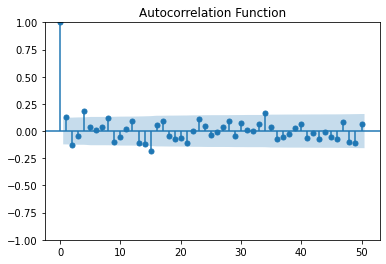

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


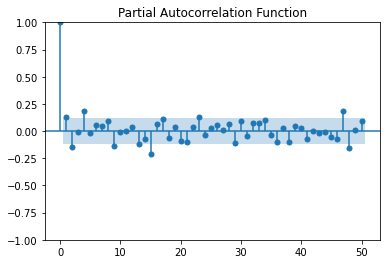

In [68]:
plot_acf(df_best['Close diff'], lags=50)
plt.title('Autocorrelation Function')
plt.show()

# Plot PACF
plot_pacf(df_best['Close diff'], lags=50)
plt.title('Partial Autocorrelation Function')
plt.show()


In [69]:
train_data = df_best[['Close time', 'Close']][:120]
test_data = df_best[['Close time', 'Close']][120:]


In [70]:
train_data

,Close time,Close
2,2018-07-22 23:59:00,7394.79
3,2018-07-29 23:59:00,8211.00
4,2018-08-05 23:59:00,7024.19
5,2018-08-12 23:59:00,6308.33
6,2018-08-19 23:59:00,6477.53
...,...,...
117,2020-10-04 23:59:00,10666.63
118,2020-10-11 23:59:00,11369.02
119,2020-10-18 23:59:00,11503.14
120,2020-10-25 23:59:00,13028.83


In [71]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 15)



In [72]:
train_data = train_data['Close'].asfreq('W')

sari_train = train_data[['Close']]


# Now, you can fit the model
model = SARIMAX(sari_train, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()

KeyError: "None of [Index(['Close'], dtype='object')] are in the [index]"

In [74]:
# Convert 'Close' column to a NumPy array
close_values = df_best['Close'].values.astype(float)

# Get the dates as a pandas DatetimeIndex
dates = pd.DatetimeIndex(df_best['Close time'])

# Create a pandas Series with 'Close' values as data and dates as index
train_data = pd.Series(close_values[:256], index=dates[:256])
test_data = pd.Series(close_values[256:], index=dates[256:])
train_data = train_data.asfreq('W')
test_data = test_data.asfreq("W")

# Now, you can fit the model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()


In [75]:
close_values.shape

(258,)

Text(0, 0.5, 'Error')

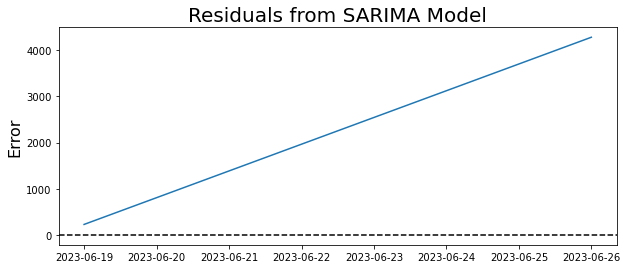

In [76]:

#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [77]:
price_series = pd.Series(close_values, index=dates)
price_series

Close time
2018-07-22 23:59:00     7394.79
2018-07-29 23:59:00     8211.00
2018-08-05 23:59:00     7024.19
2018-08-12 23:59:00     6308.33
2018-08-19 23:59:00     6477.53
                         ...   
2023-05-28 23:59:00    28065.00
2023-06-04 23:59:00    27115.21
2023-06-11 23:59:00    25925.55
2023-06-18 23:59:00    26339.97
2023-06-25 23:59:00    30462.66
Length: 258, dtype: float64

Text(0, 0.5, 'Price')

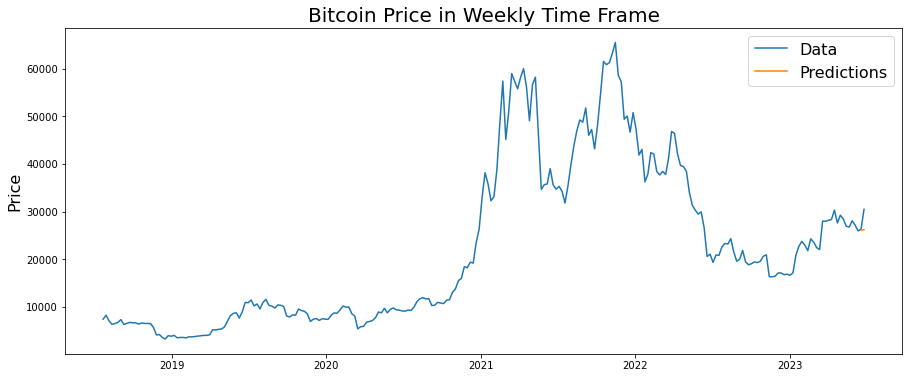

In [78]:
plt.figure(figsize=(15,6))


plt.plot(price_series)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bitcoin Price in Weekly Time Frame', fontsize=20)
plt.ylabel('Price', fontsize=16)


In [79]:
close_values

array([ 7394.79,  8211.  ,  7024.19,  6308.33,  6477.53,  6700.  ,
        7302.01,  6250.81,  6505.  ,  6708.  ,  6626.57,  6615.26,
        6339.34,  6590.11,  6489.93,  6485.85,  6449.81,  5662.  ,
        4085.78,  4161.01,  3545.37,  3228.67,  3929.71,  3801.91,
        3987.6 ,  3476.81,  3539.28,  3550.84,  3458.11,  3680.06,
        3667.58,  3743.56,  3807.75,  3916.82,  3981.14,  3992.18,
        4103.95,  5170.27,  5131.3 ,  5256.14,  5307.52,  5775.62,
        6967.31,  8148.48,  8614.43,  8725.98,  7628.13,  8953.33,
       10906.07, 10854.1 , 11406.24, 10174.18, 10589.45,  9541.54,
       10929.23, 11549.97, 10306.78, 10142.69,  9724.98, 10381.18,
       10302.01, 10028.87,  8043.82,  7854.25,  8275.01,  8223.35,
        9529.93,  9194.71,  9039.47,  8502.4 ,  6903.28,  7390.89,
        7510.11,  7118.59,  7501.44,  7388.24,  7358.75,  8184.98,
        8701.7 ,  8615.  ,  9331.51, 10151.75,  9917.27,  9936.4 ,
        8531.88,  8033.31,  5361.3 ,  5816.19,  5881.42,  6772

C:\Users\user\AppData\Local\Temp\ipykernel_11812\2314642129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_best['Close time'] = pd.to_datetime(df_best['Close time'], unit='s')


Text(0, 0.5, 'Price')

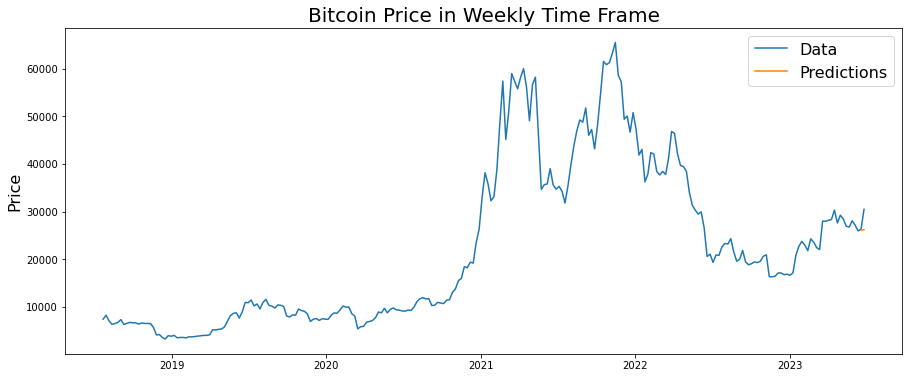

In [80]:
# Convert 'Close time' column to datetime
df_best['Close time'] = pd.to_datetime(df_best['Close time'], unit='s')

# Now, you can plot your data
plt.figure(figsize=(15,6))

df_nbest = df_best.set_index('Close time')["Close"]

plt.plot(df_best.set_index('Close time')["Close"])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bitcoin Price in Weekly Time Frame', fontsize=20)
plt.ylabel('Price', fontsize=16)


In [81]:
predictions

Close time
2023-06-18 23:59:00    26112.827550
2023-06-25 23:59:00    26180.288091
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [82]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = price_series.loc[:train_end]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    print(train_end)
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred
#-timedelta(weeks=1)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


2023-06-18 23:59:00
2023-06-25 23:59:00


Text(0, 0.5, 'Error')

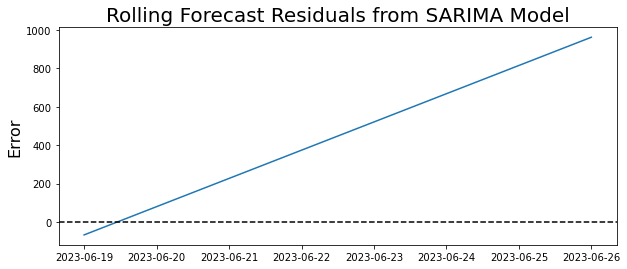

In [83]:
rolling_residuals = test_data - rolling_predictions
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Price')

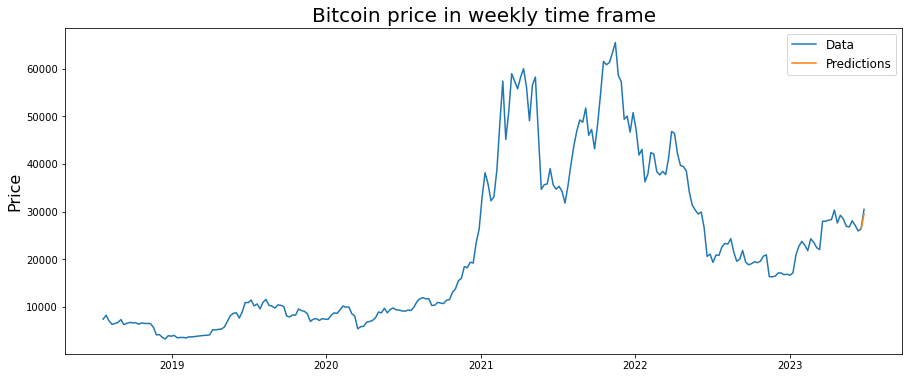

In [84]:
plt.figure(figsize=(15,6))

plt.plot(df_best.set_index('Close time')["Close"])
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Bitcoin price in weekly time frame', fontsize=20)
plt.ylabel('Price', fontsize=16)

In [85]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0746


In [86]:
residuals

Close time
2023-06-18 23:59:00     227.142450
2023-06-25 23:59:00    4282.371909
Freq: W-SUN, dtype: float64

In [87]:
forecast = model_fit.forecast(steps=3)
forecast

2023-07-02 23:59:00    29499.968415
2023-07-09 23:59:00    29509.834158
2023-07-16 23:59:00    29457.852664
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [ ]:
plt.figure(figsize=(15,6))

plt.plot(df_best.set_index('Close time')["Close"])
plt.plot(forecast)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Bitcoin price in weekly time frame', fontsize=20)
plt.ylabel('Price', fontsize=16)

In [ ]:
df_best

In [73]:
rolling_predictions

date
2022-02-13    42250.351750
2022-02-20    41773.821466
2022-02-27    38025.599380
2022-03-06    39282.663910
Freq: W-SUN, Name: close, dtype: float64